In [1]:
import sys
sys.path.append("./finrl")
from env_stocktrading import StockTradingEnv
from preprocessors import data_split

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split

import pandas as pd
import pickle 

# load the DataFrame from a pickle file
df = pd.read_pickle('dataset/processed.pkl')
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-01-01'
TRADE_START_DATE = '2021-01-02'
TRADE_END_DATE = '2023-03-24'

In [2]:
INDICATORS = ['macd','rsi_14', 'rsi_21','rsi_28',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [3]:
import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
from ray.tune.registry import register_env

from gymnasium.wrappers import EnvCompatibility

In [4]:
train = data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(df, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

80301
16211


In [5]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 378


In [6]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [7]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)

In [8]:
def env_creator_trading(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', trade)  # changed from the training environment
    
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)
    
    # specific for trading
    turbulence_threshold = env_config.get('turbulence_threshold', 70)
    risk_indicator_col = env_config.get('risk_indicator_col', 'vix')

    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling,
        turbulence_threshold=turbulence_threshold,
        risk_indicator_col=risk_indicator_col
    ))

In [9]:
from ray.rllib.agents import ppo
ray.shutdown()

In [30]:
config = ppo.PPOConfig()
config = config.environment(
    env_config={'hmax':100, 'initial_amount':1000000}
)

# Training
config = config.training()

# Resources
config = config.resources(
    num_gpus=0,
    num_cpus_per_worker=1,
    num_gpus_per_worker=0,
    num_trainer_workers=2,
    num_gpus_per_trainer_worker = 0,
    num_cpus_per_trainer_worker = 1,
)
# Framework
#config = config.framework(
#    framework="torch",
#)
# Rollouts
config = config.rollouts(
    num_rollout_workers=2,
    num_envs_per_worker=1,
)

# Additional because we are evaluating now
config = config.exploration(
    explore=False
)

In [31]:
# registering the environment to ray
register_env("finrl_trading", env_creator_trading)
#trainer = config.build(env="finrl")
trainer = ppo.PPOTrainer(env='finrl_trading', config=config)
# define trainer
#trainer = ppo.PPOTrainer(env='finrl_trading', config=config)

2023-03-30 20:29:51,398	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='finrl_trading', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl_trading').build()` instead. This will raise an error in the future!
(RolloutWorker pid=7573) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=7573)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=7572) 2023-03-30 20:29:55,493	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=7572) 2023-03-30 20:29:55,493	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(Roll

In [12]:
# load saved agent
#cwd_checkpoint = f"results/checkpoints/ppo_{total_episodes+1}/checkpoint_0000{total_episodes+1}"
#print(f"Restoring from checkpoint {total_episodes+1}")
cwd_checkpoint = 'model/checkpoint_001000'
trainer.restore(cwd_checkpoint)

2023-03-30 20:28:56,159	INFO trainable.py:791 -- Restored on 172.24.67.242 from checkpoint: model/checkpoint_001000
2023-03-30 20:28:56,160	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 1000, '_timesteps_total': None, '_time_total': 11608.134165763855, '_episodes_total': 1438}


In [13]:
import time 
def DRL_prediction(model, environment):
    start = time.time()
    """make a prediction"""
    state = environment.reset()
    for i in range(len(environment.df.index.unique())):
        action = model.compute_single_action(state)
        state, reward, done, _ = environment.step(action)
        if i == (len(environment.df.index.unique()) - 2):
            account_memory = environment.save_asset_memory()
            actions_memory = environment.save_action_memory()
        if done:
            break
    print("Test Finished!")
    print((time.time()-start),'s')
    return account_memory, actions_memory

In [37]:
df_account_value, df_actions = DRL_prediction(
    model=trainer, 
    environment = e_trade_gym)
df_actions.sum()

Test Finished!
1.8877089023590088 s


AAPL      0
AMGN      0
AXP       0
BA        0
CAT       0
CRM       0
CSCO      0
CVX       0
DIS       0
GS      558
HD        0
HON       0
IBM       0
INTC      0
JNJ       0
JPM       0
KO        0
MCD       0
MMM       0
MRK     558
MSFT      0
NKE       0
PG        0
TRV       0
UNH       0
V         0
VZ        0
WBA       0
WMT       0
dtype: int64

In [27]:
#df_account_value.tail()

In [28]:
#df_actions.tail(100)

In [33]:
df_actions.sum()

AAPL      0
AMGN      0
AXP       0
BA        0
CAT       0
CRM       0
CSCO      0
CVX       0
DIS       0
GS      558
HD        0
HON       0
IBM       0
INTC      0
JNJ       0
JPM       0
KO        0
MCD       0
MMM       0
MRK     558
MSFT      0
NKE       0
PG        0
TRV       0
UNH       0
V         0
VZ        0
WBA       0
WMT       0
dtype: int64

In [18]:
df_actions.to_csv('actions1.csv', index=False)

In [19]:
import datetime
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
#perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.009199
Cumulative returns     0.020520
Annual volatility      0.215642
Sharpe ratio           0.150011
Calmar ratio           0.032402
Stability              0.215721
Max drawdown          -0.283899
Omega ratio            1.026271
Sortino ratio          0.214469
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.959054
Daily value at risk   -0.027040
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [20]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (558, 8)
Annual return          0.026560
Cumulative returns     0.059761
Annual volatility      0.163547
Sharpe ratio           0.242307
Calmar ratio           0.121052
Stability              0.037858
Max drawdown          -0.219408
Omega ratio            1.041677
Sortino ratio          0.339596
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.933170
Daily value at risk   -0.020448
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (558, 8)


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2021-01-04
End date,2023-03-23
Total months,26
,Backtest
Annual return,0.92%
Cumulative returns,2.052%
Annual volatility,21.564%
Sharpe ratio,0.15
Calmar ratio,0.03
Stability,0.22
Max drawdown,-28.39%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.39,2022-01-03,2023-01-05,NaT,NaN
1,7.53,2021-08-16,2021-10-04,2021-11-18,69
2,5.11,2021-02-17,2021-03-04,2021-03-12,18
3,4.82,2021-12-10,2021-12-20,2021-12-27,12
4,2.85,2021-01-26,2021-01-29,2021-02-04,8


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'ob

Stress Events,mean,min,max
New Normal,0.01%,-5.25%,7.87%


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


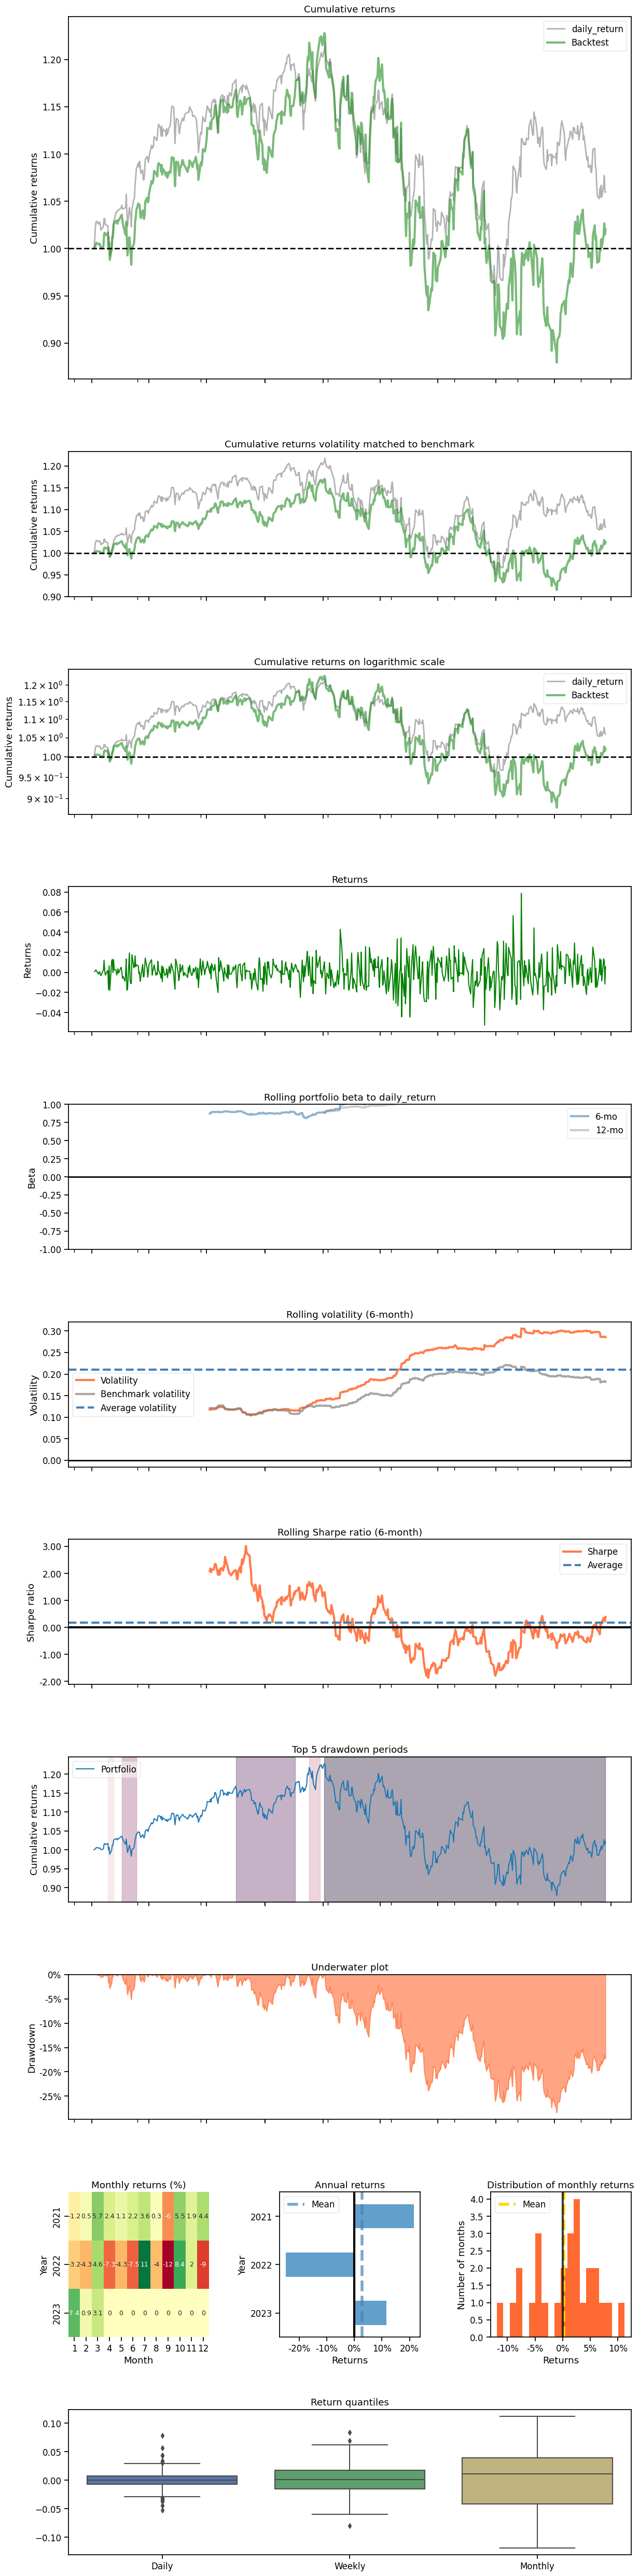

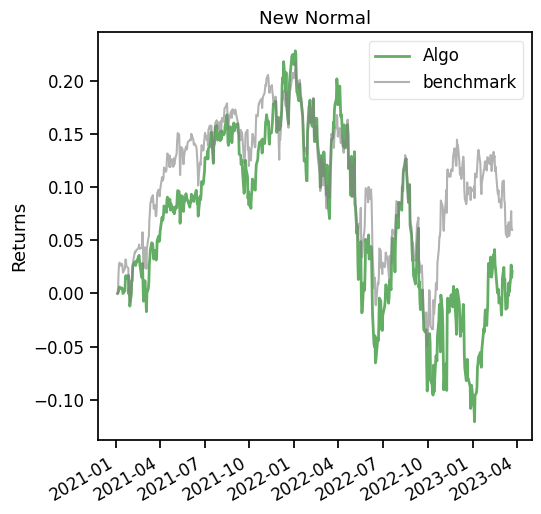

In [21]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])